# Project Three
- **Student**: Nunzio D'Amore
- **Student ID**: 329163
## Detecting Gravitational Waves in a Noisy Interferometer Signal

This project focuses on analyzing and enhancing an interferometer signal in order to compare it with a template signal. The goal is to determine if and where a gravitational wave is present within the signal.

### Data Description

The data consists of two files:
- **dati H1 32s progetto 3.txt**: Contains the interferometer strain, which is a noisy signal that may include the detected gravitational wave.
- **template.txt**: Contains the theoretical template of the gravitational wave.

### Methodology

We use various techniques to enhance and detect the presence of the gravitational wave. The process is divided into the following steps:

1. **Loading Data**: Importing the necessary datasets for analysis.
2. **Signal analysis**: Analyzing the signal by visualizing key information such as the raw signal, power spectral density (PSD), and spectrogram.
3. **Preprocessing**: Applying a filter to emphasize the frequencies where the template has higher intensity, improving signal clarity.
4. **Template Matching**: Searching for the template within the signal by calculating the Signal-to-Noise Ratio (SNR) peak and identifying the best correlation point in time.
5. **Result Visualization**: Displaying the results of the analysis for interpretation and verification.


In [11]:
# Importing useful libraries
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("./"), '..')))

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.fft import fft, ifft
import plot_settings as plot_settings
from scipy.signal import butter, sosfiltfilt

### 1. Loading data

In [12]:
plot_settings.set_theme('dark')

# Loading data
data_file = "dati H1 32s progetto 3.txt"
template_file = "template.txt"
data = np.loadtxt(data_file)
template = np.loadtxt(template_file)

In [13]:
time = data[:, 0]
strain = data[:, 1]

# Computing data informations
# Sampling
dt = time[1] - time[0]
# Sampling frequency
fs = 1 / dt
# Signal duration
T = len(time) * dt
# Resolution
df = 1 / T

template_length = len(template)

### 2. Signal Analysis

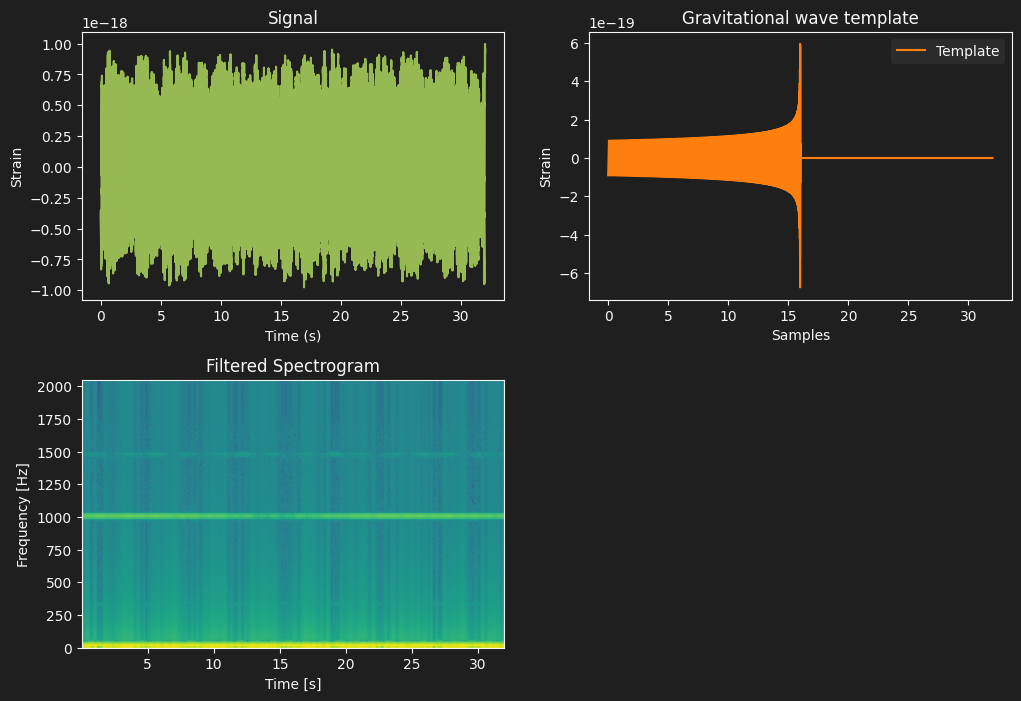

In [14]:

plot_settings.figure(figsize=(12,8))
plot_settings.subplot(2,2,1,"Time (s)","Strain")
plot_settings.title("Signal")

plt.plot((time-time[0]), strain, label="Strain", color=plot_settings.color(4))

plot_settings.subplot(2, 2, 2,"Samples", "Strain")
plot_settings.title("Gravitational wave template")
plt.plot(np.linspace(0,len(template)*dt,len(template)),template, label="Template", color=plot_settings.color(5))
plot_settings.legend()

plot_settings.subplot(2,2,3,ylabel="Frequency [Hz]", xlabel="Time [s]")
plot_settings.title("Filtered Spectrogram")
plt.specgram(strain, Fs= int(fs), NFFT=256, window=np.hamming(256))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

In [15]:
# Stima del Power Spectral Density (PSD) usando Welch
frequencies, psd = welch(strain, fs=fs, nperseg=fs//2)

# Stima del Power Spectral Density (PSD) usando Welch
frequencies_temp, psd_temp = welch(template, fs=fs, nperseg=fs//2)


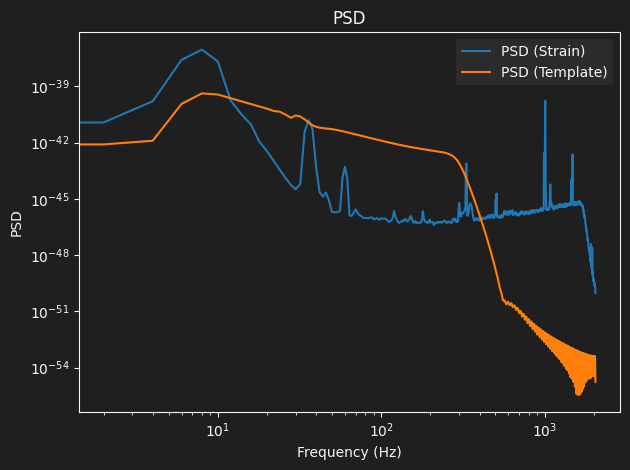

In [16]:

plot_settings.figure()
plot_settings.subplot(1,1,1,"Frequency (Hz)","PSD")
plot_settings.title("PSD")

plt.loglog(frequencies, psd, label="PSD (Strain)")
plt.loglog(frequencies_temp, psd_temp, label="PSD (Template)", color=plot_settings.color(5))

plot_settings.legend()
plt.tight_layout()
plt.show()

### 3. Preprocessing
Enhancing the signal by applying a Butterworth bandpass filter, based on the previously visualized data. 

The filter strengthens the frequencies where the template has more power. 

- We apply a filter with a lowcut of 20 and an highcut of 260 of 6th order to both the template and signal.
- We then compute the filtered strain and template psd.
- We finally plot the results showing the filtered signal and template, the pds comparison and the spectogram.

In [17]:
# Keeping the frequencies where the template 
# has more power
lowcut = 15
highcut = 260
order = 6

# Using butterworth as a bandpass on
# both the strain and template
sos = butter(order, [lowcut, highcut], btype='bandpass', fs=fs, output='sos')
filtered_strain = sosfiltfilt(sos, strain)
filtered_template = sosfiltfilt(sos, template)

In [18]:
# Computing filtered strain and template psd using welch
frequencies_filtered, psd_filtered = welch(filtered_strain, fs=fs, nperseg=fs//2)
frequencies_filt_temp, psd_filt_temp = welch(filtered_template, fs=fs, nperseg=fs//2)

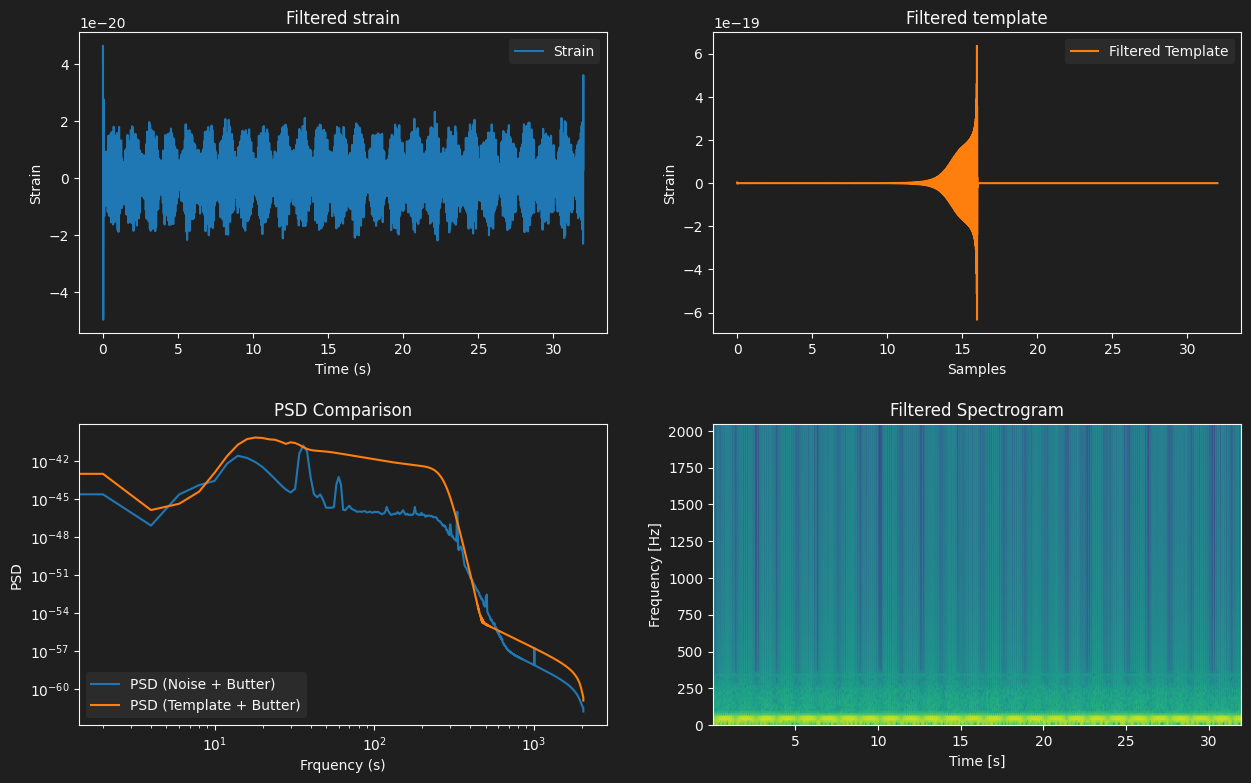

In [19]:
# Plotting results
plot_settings.figure(figsize=(15, 9))
plot_settings.subplot(2, 2, 1,"Time (s)", "Strain")
plot_settings.title("Filtered strain")
plt.plot(time-time[0], filtered_strain, label="Strain")
plot_settings.legend()

plot_settings.subplot(2, 2, 2,"Samples", "Strain")
plot_settings.title("Filtered template")
plt.plot(np.linspace(0,len(filtered_template)*dt,len(filtered_template)),filtered_template, label="Filtered Template", color=plot_settings.color(5))
plot_settings.legend()

plot_settings.subplot(2, 2, 3,"Frquency (s)", "PSD")
plot_settings.title("PSD Comparison")
plt.loglog(frequencies_filtered, psd_filtered, label="PSD (Noise + Butter)")
plt.loglog(frequencies_filt_temp, psd_filt_temp, label="PSD (Template + Butter)")
plot_settings.legend()

# Plotting spectogram
plot_settings.subplot(2,2,4,ylabel="Frequency [Hz]", xlabel="Time [s]")
plot_settings.title("Filtered Spectrogram")
plt.specgram(filtered_strain, Fs= int(fs), NFFT=256, window=np.hamming(256))
plt.subplots_adjust(wspace=0.2, hspace=0.3)

### 4. Template matching
This section will compute the SNR index based on the filtered signals and find its peak to find the best alignment for the template signal

# Peak SNR Calculation with Matched Filter

## Overview
This code performs a signal processing operation to find the peak of the Signal-to-Noise Ratio (SNR) by comparing a template signal and a strain signal using the matched filter technique.

The following steps are included:
1. Interpolation of the Power Spectral Density (PSD) to match the length of the strain data.
2. Computation of the Fast Fourier Transforms (FFT) of the filtered strain and template.
3. Normalization of the template in the frequency domain.
4. Calculation of the integrand for the matched filter.
5. Identification of the peak of the SNR in the time domain.

## Mathematical Formulas

### Interpolating PSD
The PSD is interpolated to match the length of the strain data:
$$
\text{psd\_interp}(f) = \text{interp}(\text{frequencies}, \text{psd}, f)
$$
where \( f \) is the frequency.

### FFT Calculation of Filtered Signals
The FFTs of the filtered strain and template are computed:
$$ 
\text{FFT}(\text{filtered\_strain}) = \int \text{filtered\_strain}(t) e^{-2\pi i f t} \, dt
$$
$$
\text{FFT}(\text{filtered\_template}) = \int \text{filtered\_template}(t) e^{-2\pi i f t} \, dt
$$
The conjugate of the FFT of the template is also calculated:
$$
\text{FFT\_template\_conjugate}(f) = \left( \text{FFT}(\text{filtered\_template})(f) \right)^*
$$ 

### Template Normalization
The template is normalized using the PSD:
$$
\text{template\_norm}(f) = \frac{\text{FFT\_template}(f) \cdot \text{FFT\_template\_conjugate}(f)}{\text{psd\_interp}(f)}
$$
The normalization constant is obtained by summing the real part of the template norm:
$$
\text{norm} = \sum \text{Re}(\text{template\_norm}(f)) \Delta f
$$
where $\Delta f$ is the frequency bin width.

### Matched Filter Calculation
The integrand for the matched filter is:
$$
\text{integrand}(f) = \frac{\text{FFT}(\text{filtered\_strain})(f) \cdot \text{FFT\_template\_conjugate\_normalized}(f)}{\text{psd\_interp}(f)}
$$
The matched filter SNR in the time domain is:
$$
\text{SNR\_time\_domain}(t) = \frac{1}{\Delta t} \left| \text{IFFT}(\text{integrand}) \right|
$$


In [20]:
# Interpolating psd so it has the same length as the strain data
psd_interp = np.interp(np.fft.fftfreq(len(strain), d=dt), frequencies, psd)

# Computing filtered signals ffts
fft_filtered_strain = dt * fft(filtered_strain)
fft_template = dt * fft(filtered_template)
fft_template_conjugate = fft_template.conjugate() # template conjugate

# Computing template norm to normalize the template
# and its coniugate's fft
template_norm = np.divide(fft_template*fft_template_conjugate, psd_interp)
norm = sum(np.real(template_norm))
norm = norm*df

# Normalizing
fft_template_normalized = np.divide(fft_template,np.sqrt(norm))
fft_template_conjugate_normalized = np.divide(fft_template_conjugate,np.sqrt(norm))

integrand = np.divide(fft_filtered_strain*fft_template_conjugate_normalized,psd_interp)

# Using matched filter
snr_time_domain = np.abs(ifft(integrand)/dt)

# Identifying snr peak
peak_snr_idx = np.argmax(snr_time_domain)
peak_time = time[peak_snr_idx] - time[0] # Counting from 0
peak_snr_value = snr_time_domain[peak_snr_idx]

print(f"SNR peak time location [from 0]: {peak_time:.3f}")
print("SNR peak value:", peak_snr_value)

SNR peak time location [from 0]: 16.019
SNR peak value: 46.256371656


### 5. Result Visualization
- Plotting the correctly positioned gravitational wave with respect to the interferometer signal.
- Plotting SNR in time domain.

In [21]:
# This function is used to plot the peak
# vertical lign at a given location in time
def plot_peak(time):
    plt.axvline(time, color=plot_settings.color(1), linestyle='--', label="SNR Peak")

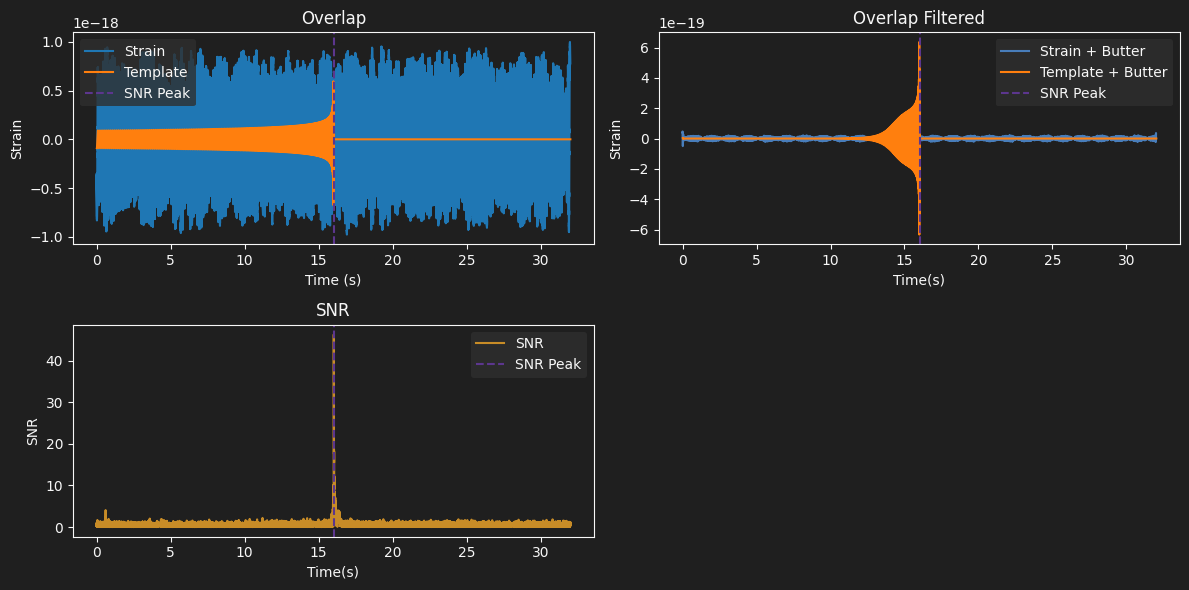

In [22]:

half_template = len(template) // 2
offset = peak_snr_idx - half_template

shifted_times = (time-time[0])
# Risultati e visualizzazione
plot_settings.figure(figsize=(12, 6))

# Normal strain and template overlap
plot_settings.subplot(2, 2, 1,"Time (s)", "Strain")
plot_settings.title("Overlap")
plt.plot(shifted_times, strain, label="Strain")
plt.plot(shifted_times + offset * dt,template, label="Template", color=plot_settings.color(5))
plot_peak(peak_time)
plot_settings.legend()

# Filtered strain and template overlap
plot_settings.subplot(2, 2, 2,"Time(s)", "Strain")
plot_settings.title("Overlap Filtered")
plt.plot(shifted_times, filtered_strain, label="Strain + Butter", color=plot_settings.color(3))
plt.plot(shifted_times + offset*dt,filtered_template, label="Template + Butter", color=plot_settings.color(5))
plot_peak(peak_time)
plot_settings.legend()

# SNR in time domain
plot_settings.subplot(2, 2, 3,"Time(s)", "SNR")
plt.plot(shifted_times, snr_time_domain, label="SNR", color=plot_settings.color(0))
plot_peak(peak_time)
plot_settings.title("SNR")
plot_settings.legend()

plt.tight_layout()
plt.show()
